# Beam propagation demo
Example code to demonstrate the propagation of all kinds of weird beams that could be made inside a TEM (and originate in original work in optics)  
(c) 2022 Jo Verbeeck  
EMAT, University of Antwerp, Belgium  
jo.verbeeck@uantwerp.be  

use your imagination to expand and surprise me with new ideas/applications!

In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#create sampling grid
kpoints=512 #the sampling

#some parameters of the microscope
lmbda=2e-12 #wavelength of the fast electrons [m]
k0=2*np.pi/lmbda #wavevector of the fast electrons [1/m]
alpha=21.4e-3 #the half angle of the final probe in the sample plane [rad] (can be typically varied in the condensor settings for STEM mode, bigger gives smaller probes as long as aberrations allow)
#alpha=0.2e-3 #the half angle of the final probe in the sample plane [rad] (can be typically varied in the condensor settings for STEM mode, bigger gives smaller probes as long as aberrations allow)

#set up a grid in reciprocal space (the space of the grating, typically the condensor plane)
oversample=4 #the higher this is, the better the sampling in real space, but the worse in k space
kmax=k0*oversample*alpha #highest transverse k vector that we will take into acount
k=np.linspace(-kmax,kmax,kpoints)
[Kx,Ky]=np.meshgrid(k,k) #create 2D grid of k points
K=np.sqrt(Kx**2+Ky**2)
Theta=K/k0 #and convert to angles
PHI=np.arctan2(Kx,Ky) #angle in the 2D plane

#set up a grid in real space (the space of the final probe, typically the sample plane)
xmax=kpoints/kmax
x=np.linspace(-xmax,xmax,kpoints)
[X,Y]=np.meshgrid(x,x) #and create a 2D grid with it
R=np.sqrt(X**2+Y**2)
rdisc=2/(k0*alpha)

outermask=Theta<alpha #clip any reciprocal components above Kmax, needed as the grating will enforce this maximum anyway


In [103]:
#a set of functions to create specific electron waves
#to do: make cleaner passing of parameters (less hard coding and more unified)
def circular_wave(Theta,alpha):
    #conventional idealised (no aberrations) STEM beam from a circular aperture
    #easy to add aberrations as well
    wave=Theta<alpha
    return wave

def vortex_wave(Theta,alpha,PHI,m):
    #conventional idealised (no aberrations) STEM beam from a circular aperture
    #easy to add aberrations as well
    wave=(Theta<alpha)*np.exp(1j*m*PHI)
    return wave

def airy_wave(Theta,alpha,Kx,Ky,k0):
    #approximation to an Airy wave (no amplitude modulation)
    a=2*(1/(k0*alpha)**3) #strength factor determining the focal range and size of the probe
    outermask=Theta<alpha
    wave=outermask*np.exp(1j*2*np.pi*a*((Kx+Ky)**3+(Kx-Ky)**3))
    return wave
    
def bessel_wave(K,PHI,k0,alpha,m,ringwidth):
    #an approximate Bessel beam (a ring of finite width in k space, mathematically should be infinitely thin ring)        
    #with optional topological charge of m
    kouter=k0*alpha
    kinner=k0*(alpha-ringwidth)
    wave=((K>kinner)*(K<kouter))*np.exp(1j*m*PHI) #a ring like illumination
    return wave

def helicon_wave(K,PHI,k0,alpha1,alpha2,m1,m2,ringwidth):
    #attempt to make a snake bessel wave (not sure it is 100% correct)
    #by interfering 2 bessel beams with different topological charge m1 and m2 and different opening angle
    #waves, rotation speed of the helix is dependent on (k1^2-k2^2)/(m1-m2)
    #see Patterson paper 
    w1=ringwidth
    w2=ringwidth*alpha1/alpha2 #to give both bessels same total intensity
    bessel1=bessel_wave(K,PHI,k0,alpha1,m1,w1)
    bessel2=bessel_wave(K,PHI,k0,alpha2,m2,w2)
    wave=bessel1+bessel2      
    return wave

def axicon_wave(K,k0,alpha,strength):
    #quasi Bessel produced with an Axicon (doesn't seem to do what I want)
    a=strength/(k0*alpha) #strength of the axicon
    wave=outermask*np.exp(1j*2*np.pi*a*K)
    return wave
        
def nholes_wave(K,k0,alpha,n):        
    #nxnplane waves...(nxn holes in an aperture)
    ksize=k0*alpha/(3*n)
    wave=np.zeros(K.shape)
    for i in range(n):
        for j in range(n):
            ki=(i+0.5-n/2)*k0*alpha/n
            kj=(j+0.5-n/2)*k0*alpha/n
            Kij=np.sqrt((Kx+ki)**2+(Ky+kj)**2)
            holeij=Kij<ksize
            wave=wave+holeij
    return wave

In [43]:
def phplotrgb(A): #a helper function to create rgb values in imshow to recreate a phaseplot
    #the color represents the phase angle and the intensity is related to the amplitude
    amplitudescaled=np.abs(A)/np.max(np.abs(A))
    cmap = mpl.cm.hsv #this is a cyclic color map which is nice for phase
    norm = mpl.colors.Normalize(-np.pi, np.pi)
    rgbmatrix = cmap((np.angle(A)+np.pi)/(2*np.pi)) # convert phase values to rgb
    #but now scale intensity of the rgb values
    rgbmatrix[:,:,0]=rgbmatrix[:,:,0]*amplitudescaled
    rgbmatrix[:,:,1]=rgbmatrix[:,:,1]*amplitudescaled
    rgbmatrix[:,:,2]=rgbmatrix[:,:,2]*amplitudescaled
    return rgbmatrix


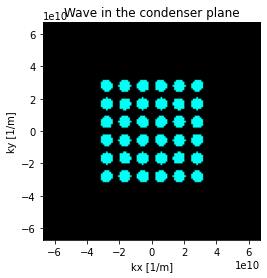

In [106]:
#choose a wave and plot it
#uncomment any of those to make a choice (see for more options the defined functions above and feel free to create more or to
#play with variables)

#vortex
#m=1
#wave=vortex_wave(Theta,alpha,PHI,m)

#round aperture
#wave=circular_wave(Theta,alpha)

#airy wave
#wave=airy_wave(Theta,alpha,Kx,Ky,k0)

#bessel wave
#m=0 #optional to give vorticity to Bessel wave
#ringwidth=0.1*alpha #the width of the ring, an ideal bessel has ringwidth=0, making it wider limits the range over
#which the Bessel doesnt diverge. Of course in reality zero width would pass no electrons and is only relevant from an 
#academc point of view
#wave=bessel_wave(K,PHI,k0,alpha,m,ringwidth)

#helicon wave
#alpha1=alpha
#alpha2=0.8*alpha#
#m1=0
#m2=-1
#ringwidth=0.05*alpha
#wave=helicon_wave(K,PHI,k0,alpha1,alpha2,m1,m2,ringwidth)

#axicon, this is an approximation to an analytical bessel with infinite thin ring
#strength=10
#wave=axicon_wave(K,k0,alpha,strength)

#create nxn holes
n=6
wave=nholes_wave(K,k0,alpha,n)   

#show phase and amplitude of the wave in a fancy plot
fig, ax = plt.subplots()
im = ax.imshow(phplotrgb(wave),
               origin='lower', extent=[-kmax, kmax, -kmax, kmax])
plt.title('Wave in the condenser plane')
plt.xlabel('kx [1/m]')
plt.ylabel('ky [1/m]')
ax.set_xlim(-k0*alpha, k0*alpha)
ax.set_ylim(-k0*alpha, k0*alpha)
plt.show()

In [94]:
#now calculate the distribution near focus in real space
#shift up and down the focal plane using a defocus term in the condensor
#plane (Fresnel propagator method). This only works for a 'reasonable'
#defocus range depending heavily on sampling
focusrange=200e-9
focussteps=200
df=np.linspace(-focusrange/2,focusrange/2,focussteps)
I=np.zeros((kpoints,kpoints,focussteps)) #preallocate memory for I (speed)
for k in range(focussteps):   
    defocus=np.exp(1j*k0*(1/2)*Theta**2*df[k])        
    resultwave=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(wave*defocus))) #Fourier transforming brings us to the observation plane
    I[:,:,k]=np.abs(resultwave)**2 #store it in a 3D dataset
    

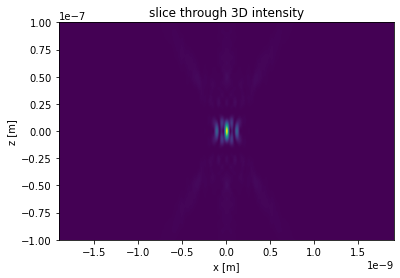

In [95]:
#make cross sections through this 3D cube
fig, ax = plt.subplots()
ind=int(kpoints/2)
zslice=np.transpose(np.squeeze(I[ind,:,:]))
im = ax.imshow(zslice,
               origin='lower', extent=[-xmax, xmax, -focusrange/2, focusrange/2],
               vmax=np.max(zslice), vmin=np.min(zslice), aspect='auto')
plt.title('slice through 3D intensity')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
ax.set_xlim(-xmax, xmax)
ax.set_ylim(-focusrange/2, focusrange/2)
plt.show()